In [2]:
import numpy as np 
import pandas as pd
from sklearn.model_selection import train_test_split

import nltk
from nltk.corpus import stopwords
from nltk.classify import SklearnClassifier

from wordcloud import WordCloud,STOPWORDS
import matplotlib.pyplot as plt
%matplotlib inline

from subprocess import check_output

In [4]:
data = pd.read_csv('GOP_Sentiment.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13871 entries, 0 to 13870
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         13871 non-null  int64  
 1   candidate                  13775 non-null  object 
 2   candidate_confidence       13871 non-null  float64
 3   relevant_yn                13871 non-null  object 
 4   relevant_yn_confidence     13871 non-null  float64
 5   sentiment                  13871 non-null  object 
 6   sentiment_confidence       13871 non-null  float64
 7   subject_matter             13545 non-null  object 
 8   subject_matter_confidence  13871 non-null  float64
 9   candidate_gold             28 non-null     object 
 10  name                       13871 non-null  object 
 11  relevant_yn_gold           32 non-null     object 
 12  retweet_count              13871 non-null  int64  
 13  sentiment_gold             15 non-null     obj

In [5]:
data.head()

,id,candidate,candidate_confidence,relevant_yn,relevant_yn_confidence,sentiment,sentiment_confidence,subject_matter,subject_matter_confidence,candidate_gold,name,relevant_yn_gold,retweet_count,sentiment_gold,subject_matter_gold,text,tweet_coord,tweet_created,tweet_id,tweet_location,user_timezone
0,1,No candidate mentioned,1.0,yes,1.0,Neutral,0.6578,None of the above,1.0000,NaN,I_Am_Kenzi,NaN,5,NaN,NaN,RT @NancyLeeGrahn: How did everyone feel about...,NaN,2015-08-07 09:54:46 -0700,629697200650592256,NaN,Quito
1,2,Scott Walker,1.0,yes,1.0,Positive,0.6333,None of the above,1.0000,NaN,PeacefulQuest,NaN,26,NaN,NaN,RT @ScottWalker: Didn't catch the full #GOPdeb...,NaN,2015-08-07 09:54:46 -0700,629697199560069120,NaN,NaN
2,3,No candidate mentioned,1.0,yes,1.0,Neutral,0.6629,None of the above,0.6629,NaN,PussssyCroook,NaN,27,NaN,NaN,RT @TJMShow: No mention of Tamir Rice and the ...,NaN,2015-08-07 09:54:46 -0700,629697199312482304,NaN,NaN
3,4,No candidate mentioned,1.0,yes,1.0,Positive,1.0000,None of the above,0.7039,NaN,MattFromTexas31,NaN,138,NaN,NaN,RT @RobGeorge: That Carly Fiorina is trending ...,NaN,2015-08-07 09:54:45 -0700,629697197118861312,Texas,Central Time (US & Canada)
4,5,Donald Trump,1.0,yes,1.0,Positive,0.7045,None of the above,1.0000,NaN,sharonDay5,NaN,156,NaN,NaN,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,NaN,2015-08-07 09:54:45 -0700,629697196967903232,NaN,Arizona


In [6]:
# Keeping only the neccessary columns
data = data[['text','sentiment']]

In [7]:
# Splitting the dataset into train and test set
train, test = train_test_split(data,test_size = 0.1)
# Removing neutral sentiments
train = train[train.sentiment != "Neutral"]

Positive words


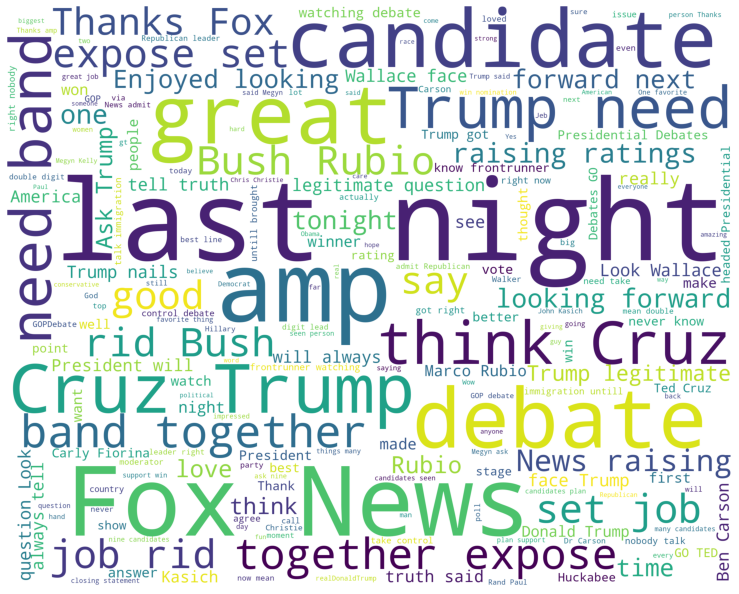

Negative words


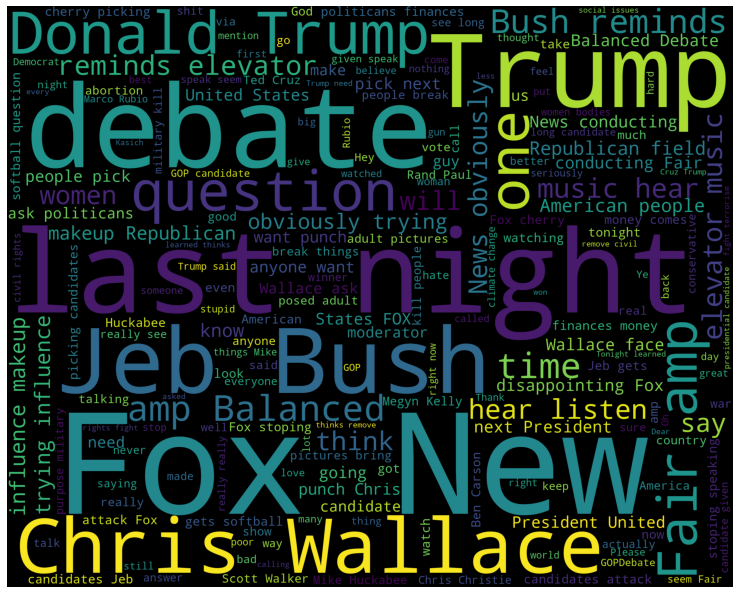

In [8]:
train_pos = train[ train['sentiment'] == 'Positive']
train_pos = train_pos['text']
train_neg = train[ train['sentiment'] == 'Negative']
train_neg = train_neg['text']

def wordcloud_draw(data, color = 'black'):
    words = ' '.join(data)
    cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and not word.startswith('#')
                                and word != 'RT'
                            ])
    wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color=color,
                      width=2500,
                      height=2000
                     ).generate(cleaned_word)
    plt.figure(1,figsize=(13, 13))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()
    
print("Positive words")
wordcloud_draw(train_pos,'white')
print("Negative words")
wordcloud_draw(train_neg)

In [9]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [10]:
tweets = []
stopwords_set = set(stopwords.words("english"))

for index, row in train.iterrows():
    words_filtered = [e.lower() for e in row.text.split() if len(e) >= 3]
    words_cleaned = [word for word in words_filtered
        if 'http' not in word
        and not word.startswith('@')
        and not word.startswith('#')
        and word != 'RT']
    words_without_stopwords = [word for word in words_cleaned if not word in stopwords_set]
    tweets.append((words_without_stopwords, row.sentiment))

test_pos = test[ test['sentiment'] == 'Positive']
test_pos = test_pos['text']
test_neg = test[ test['sentiment'] == 'Negative']
test_neg = test_neg['text']

In [11]:
# Extracting word features
def get_words_in_tweets(tweets):
    all = []
    for (words, sentiment) in tweets:
        all.extend(words)
    return all

def get_word_features(wordlist):
    wordlist = nltk.FreqDist(wordlist)
    features = wordlist.keys()
    return features
w_features = get_word_features(get_words_in_tweets(tweets))

def extract_features(document):
    document_words = set(document)
    features = {}
    for word in w_features:
        features['contains(%s)' % word] = (word in document_words)
    return features

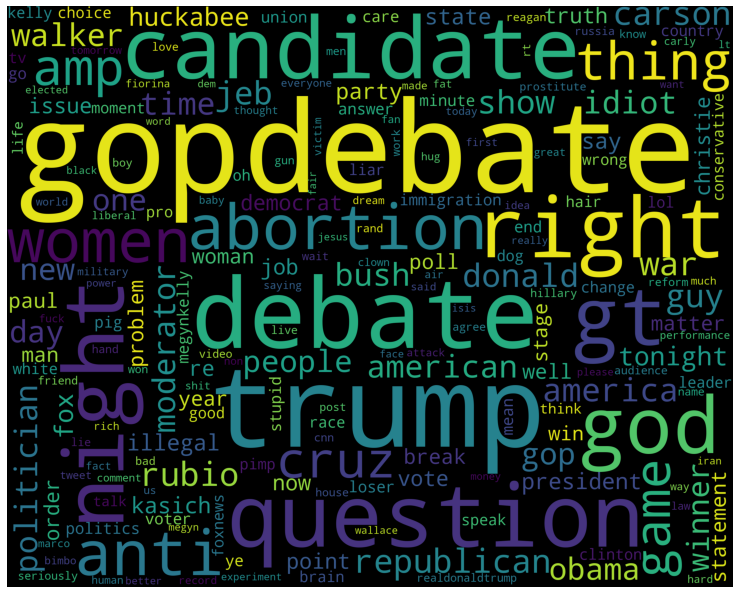

In [12]:
wordcloud_draw(w_features)

In [13]:
# Training the Naive Bayes classifier
training_set = nltk.classify.apply_features(extract_features,tweets)
classifier = nltk.NaiveBayesClassifier.train(training_set)

In [14]:
neg_cnt = 0
pos_cnt = 0
for obj in test_neg: 
    res =  classifier.classify(extract_features(obj.split()))
    if(res == 'Negative'): 
        neg_cnt = neg_cnt + 1
for obj in test_pos: 
    res =  classifier.classify(extract_features(obj.split()))
    if(res == 'Positive'): 
        pos_cnt = pos_cnt + 1
        
print('[Negative]: %s/%s '  % (len(test_neg),neg_cnt))        
print('[Positive]: %s/%s '  % (len(test_pos),pos_cnt))    

[Negative]: 852/804 
[Positive]: 215/87 


#LSTM Sentiment Analysis | Keras

In [17]:
import numpy as np 
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re

import warnings
warnings.filterwarnings("ignore")

In [18]:
data = data[data.sentiment != "Neutral"]
data['text'] = data['text'].apply(lambda x: x.lower())
data['text'] = data['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))

print(data[ data['sentiment'] == 'Positive'].size)
print(data[ data['sentiment'] == 'Negative'].size)

for idx,row in data.iterrows():
    row[0] = row[0].replace('rt',' ')
    
max_fatures = 2000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(data['text'].values)
X = tokenizer.texts_to_sequences(data['text'].values)
X = pad_sequences(X)

4472
16986


In [19]:
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 28, 128)           256000    
                                                                 
 spatial_dropout1d (SpatialD  (None, 28, 128)          0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 196)               254800    
                                                                 
 dense (Dense)               (None, 2)                 394       
                                                                 
Total params: 511,194
Trainable params: 511,194
Non-trainable params: 0
_________________________________________________________________
None


In [20]:
Y = pd.get_dummies(data['sentiment']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.33, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(7188, 28) (7188, 2)
(3541, 28) (3541, 2)


In [21]:
batch_size = 32
model.fit(X_train, Y_train, epochs = 7, batch_size=batch_size, verbose = 2)

Epoch 1/7
225/225 - 52s - loss: 0.4312 - accuracy: 0.8144 - 52s/epoch - 233ms/step
Epoch 2/7
225/225 - 48s - loss: 0.3194 - accuracy: 0.8666 - 48s/epoch - 215ms/step
Epoch 3/7
225/225 - 46s - loss: 0.2738 - accuracy: 0.8884 - 46s/epoch - 205ms/step
Epoch 4/7
225/225 - 46s - loss: 0.2426 - accuracy: 0.8989 - 46s/epoch - 205ms/step
Epoch 5/7
225/225 - 46s - loss: 0.2163 - accuracy: 0.9090 - 46s/epoch - 205ms/step
Epoch 6/7
225/225 - 46s - loss: 0.1889 - accuracy: 0.9256 - 46s/epoch - 204ms/step
Epoch 7/7
225/225 - 46s - loss: 0.1745 - accuracy: 0.9322 - 46s/epoch - 205ms/step


In [22]:
validation_size = 1500

X_validate = X_test[-validation_size:]
Y_validate = Y_test[-validation_size:]
X_test = X_test[:-validation_size]
Y_test = Y_test[:-validation_size]
score,acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size = batch_size)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

64/64 - 1s - loss: 0.4089 - accuracy: 0.8354 - 1s/epoch - 22ms/step
score: 0.41
acc: 0.84


In [23]:
pos_cnt, neg_cnt, pos_correct, neg_correct = 0, 0, 0, 0
for x in range(len(X_validate)):
    
    result = model.predict(X_validate[x].reshape(1,X_test.shape[1]),batch_size=1,verbose = 2)[0]
   
    if np.argmax(result) == np.argmax(Y_validate[x]):
        if np.argmax(Y_validate[x]) == 0:
            neg_correct += 1
        else:
            pos_correct += 1
       
    if np.argmax(Y_validate[x]) == 0:
        neg_cnt += 1
    else:
        pos_cnt += 1



print("pos_acc", pos_correct/pos_cnt*100, "%")
print("neg_acc", neg_correct/neg_cnt*100, "%")

1/1 - 0s - 363ms/epoch - 363ms/step
1/1 - 0s - 34ms/epoch - 34ms/step
1/1 - 0s - 39ms/epoch - 39ms/step
1/1 - 0s - 34ms/epoch - 34ms/step
1/1 - 0s - 32ms/epoch - 32ms/step
1/1 - 0s - 32ms/epoch - 32ms/step
1/1 - 0s - 42ms/epoch - 42ms/step
1/1 - 0s - 32ms/epoch - 32ms/step
1/1 - 0s - 31ms/epoch - 31ms/step
1/1 - 0s - 31ms/epoch - 31ms/step
1/1 - 0s - 34ms/epoch - 34ms/step
1/1 - 0s - 32ms/epoch - 32ms/step
1/1 - 0s - 34ms/epoch - 34ms/step
1/1 - 0s - 35ms/epoch - 35ms/step
1/1 - 0s - 33ms/epoch - 33ms/step
1/1 - 0s - 31ms/epoch - 31ms/step
1/1 - 0s - 32ms/epoch - 32ms/step
1/1 - 0s - 37ms/epoch - 37ms/step
1/1 - 0s - 31ms/epoch - 31ms/step
1/1 - 0s - 33ms/epoch - 33ms/step
1/1 - 0s - 34ms/epoch - 34ms/step
1/1 - 0s - 32ms/epoch - 32ms/step
1/1 - 0s - 38ms/epoch - 38ms/step
1/1 - 0s - 35ms/epoch - 35ms/step
1/1 - 0s - 32ms/epoch - 32ms/step
1/1 - 0s - 40ms/epoch - 40ms/step
1/1 - 0s - 35ms/epoch - 35ms/step
1/1 - 0s - 34ms/epoch - 34ms/step
1/1 - 0s - 34ms/epoch - 34ms/step
1/1 - 0s - 3

In [24]:
twt = ['Meetings: Because none of us is as dumb as all of us.']
#vectorizing the tweet by the pre-fitted tokenizer instance
twt = tokenizer.texts_to_sequences(twt)
#padding the tweet to have exactly the same shape as `embedding_2` input
twt = pad_sequences(twt, maxlen=28, dtype='int32', value=0)
print(twt)
sentiment = model.predict(twt,batch_size=1,verbose = 2)[0]
if(np.argmax(sentiment) == 0):
    print("negative")
elif (np.argmax(sentiment) == 1):
    print("positive")

[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0  206  633    6  150    5   55 1055   55   46    6  150]]
1/1 - 0s - 37ms/epoch - 37ms/step
negative
